In [1]:
%run flow_tools.py

/opt/homebrew/Caskroom/miniforge/base/envs/flow/lib/python3.9/site-packages/scipy/__init__.py:146: UserWarning: A NumPy version >=1.16.5 and <1.23.0 is required for this version of SciPy (detected version 1.26.3
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"


In [2]:
from matplotlib.path import Path
from matplotlib import patches

In [3]:
folders = ['/Users/weinberz/Library/CloudStorage/Box-Box/SynCellMotifs/Flow/20220916_mesc_NGN2-SNIPR_fix_ratio/']

In [4]:
df = [load_data(folder, colnames = ['WellName', 'Sender', 'Receiver', 'Ratio', 'Condition', 'Replicate']) for folder in folders]
df = pd.concat(df)

In [5]:
#remove NAs
df2= df.loc[(df.select_dtypes(include=['number']) > 0).all(axis='columns'), :]
df2=df2.dropna()

In [6]:
#define gate for FSC-A vs SSC-A
fsc_ssc_verts = [(4e4, 1e4),
              (1e5, 2.5e4),
              (2.5e5, 1e5),
              (2.5e5, 2.5e5),
              (1e5, 6e4),
              (4e4, 2e4),
              (4e4, 5e4),
              (4e4, 1e4)]
fsc_ssc_gate = Path(fsc_ssc_verts)

ssc_verts = [(0, 1e4),
              (2e5, 1.8e5),
              (2.6e5, 1.8e5),
              (2.5e5, 1.3e5),
              (1.25e5, 7.5e4),
              (1e4, 0),
              (0, 1e4)]
ssc_gate = Path(ssc_verts)

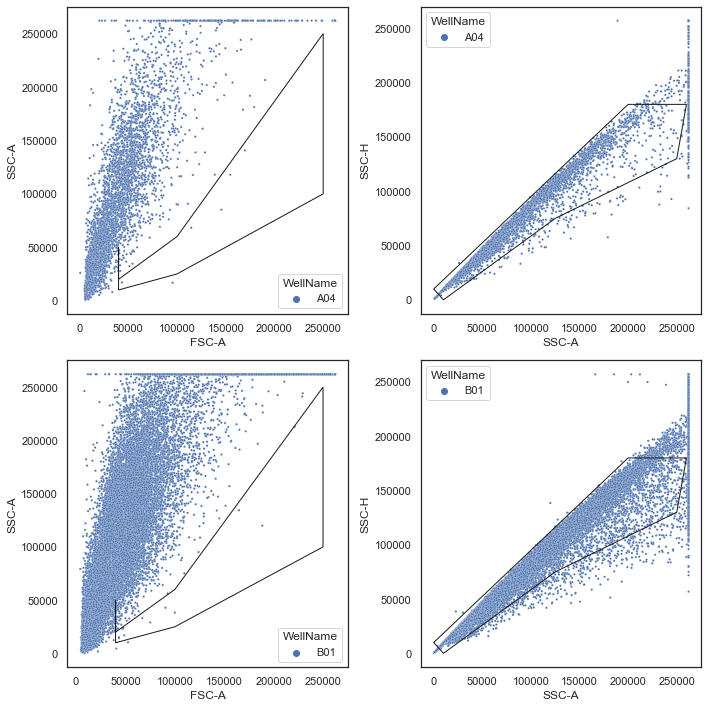

In [24]:
fig, axs = plt.subplots(2,2, figsize=[10,10])
sns.scatterplot(data=df2[(df2['WellName'].isin(['A04']))], x='FSC-A', y='SSC-A', marker='o', s=5, edgecolors=None, ax=axs[0,0], hue='WellName')
sns.scatterplot(data=df2[df2['WellName'].isin(['A04'])], x='SSC-A', y='SSC-H', marker='o', s=5, edgecolors=None, ax=axs[0,1], hue='WellName')
sns.scatterplot(data=df2[df2['WellName'].isin(['B01'])], x='FSC-A', y='SSC-A', marker='o', s=5, edgecolors=None, ax=axs[1,0], hue='WellName')
sns.scatterplot(data=df2[df2['WellName'].isin(['B01'])], x='SSC-A', y='SSC-H', marker='o', s=5, edgecolors=None, ax=axs[1,1], hue='WellName')
patch = patches.PathPatch(fsc_ssc_gate, facecolor="None", edgecolor='k')
axs[0,0].add_patch(patch)
patch = patches.PathPatch(fsc_ssc_gate, facecolor="None", edgecolor='k')
axs[1,0].add_patch(patch)
patch = patches.PathPatch(ssc_gate, facecolor="None", edgecolor='k')
axs[0,1].add_patch(patch)
patch = patches.PathPatch(ssc_gate, facecolor="None", edgecolor='k')
axs[1,1].add_patch(patch)
plt.tight_layout()

In [7]:
#filter to gate
#df2 = df2[fsc_ssc_gate.contains_points(df2[['FSC-A','SSC-A']].to_numpy())]
#df2 = df2[ssc_gate.contains_points(df2[['SSC-A', 'SSC-H']].to_numpy())]
# # gate on singlets
df2 = gate_density(df2, 0.2, x_var='SSC-A',y_var='SSC-H')

for col in df2.columns:
        if df2[col].dtype=="float32":
            df2["log"+ col]=df2[col].apply(math.log10)

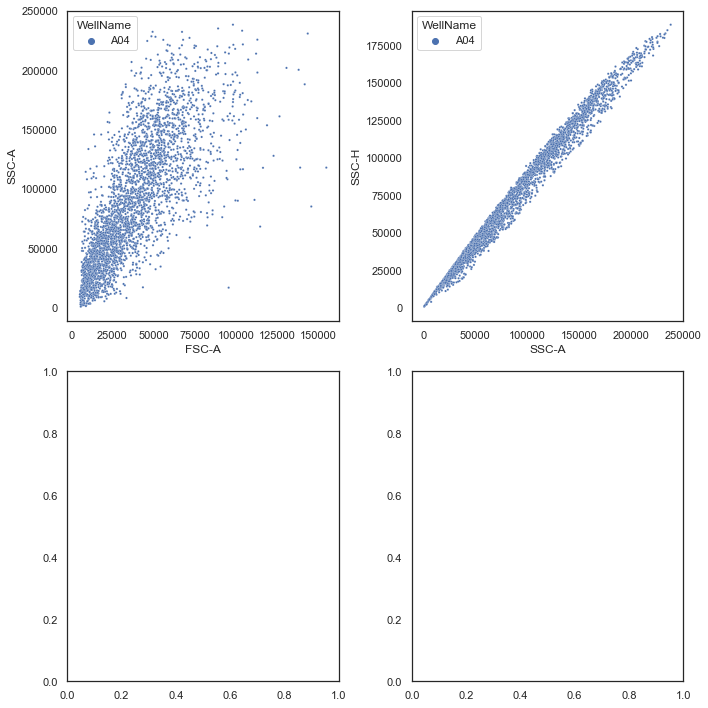

In [37]:
fig, axs = plt.subplots(2,2, figsize=[10,10])
sns.scatterplot(data=df2[(df2['WellName'].isin(['A04']))], x='FSC-A', y='SSC-A', marker='o', s=5, edgecolors=None, ax=axs[0,0], hue='WellName')
sns.scatterplot(data=df2[df2['WellName'].isin(['A04'])], x='SSC-A', y='SSC-H', marker='o', s=5, edgecolors=None, ax=axs[0,1], hue='WellName')
plt.tight_layout()

Text(0.5, 22.960000000000008, 'log <channel>')

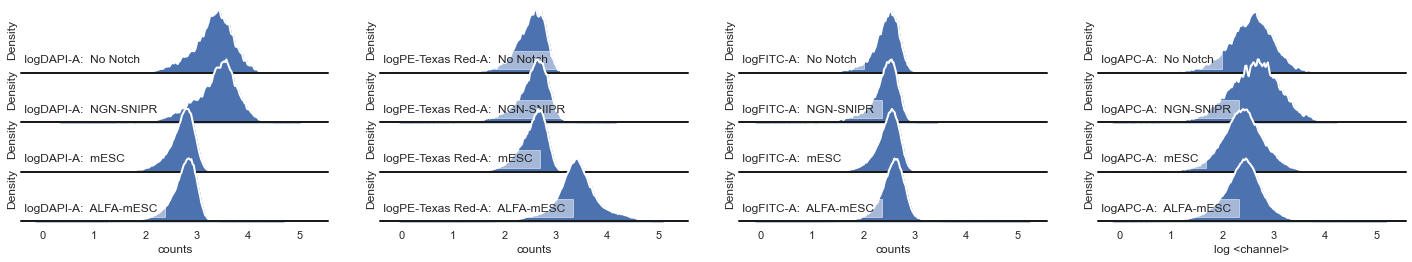

In [38]:
# To figure out what our cutoffs should be, let's look at the untransfected cells for all 4 channels:
simplified_df = (df2.reset_index()
                 .melt(value_vars=['logDAPI-A','logPE-Texas Red-A','logFITC-A','logAPC-A'], 
                       id_vars=['index','WellName','Condition'],
                       var_name='channel',
                       value_name='counts'))
g = sns.FacetGrid(data=simplified_df[simplified_df["Condition"].isin(['No Notch', 'mESC', 'NGN-SNIPR', 'ALFA-mESC'])], 
                  row = 'Condition', col='channel', sharey=False, aspect=5, height=1)
g.map(sns.kdeplot, "counts", shade=True, alpha=1, bw_adjust=0.2, clip_on=False, cut=0)
g.map(sns.kdeplot, "counts", color="w", lw=2, bw_adjust=.2, clip_on=False, cut=0)
g.map(plt.axhline, y=0, lw=2, color='k', clip_on=False)

# Set the subplots to overlap
g.fig.subplots_adjust(hspace=-.25)

for ax in g.axes.flat:
    wellname = ax.get_title().split("=")[2]
    ch = ax.get_title().split('|')[0].split('=')[1]
    ax.text(0,0.2, "{}: {}".format(wellname, ch), ha="left", va="center", 
            bbox=dict(facecolor='white', alpha=0.5), transform=ax.transAxes)
    ax.set(facecolor=(0, 0, 0, 0))

# Remove axes details that don't play well with overlap
g.set_titles("")
g.set(yticks=[])
g.despine(bottom=True, left=True)
plt.xlabel("log <channel>")

In [8]:
notches = ['No Notch', 'NGN-SNIPR']
filters = ((df2['logDAPI-A'] > 3.5) &
           (df2.Receiver.isin(notches)))
thresh = 3.8
df_summary = (df2[filters]
              .groupby(['Sender','Receiver','Ratio','Replicate'])['logAPC-A']
              .apply(lambda x: 100*(np.sum(x.values>thresh)/len(x)))
              .reset_index())
df_summary = df_summary.replace('NGN-SNIPR','NbALFA-SNIPR')

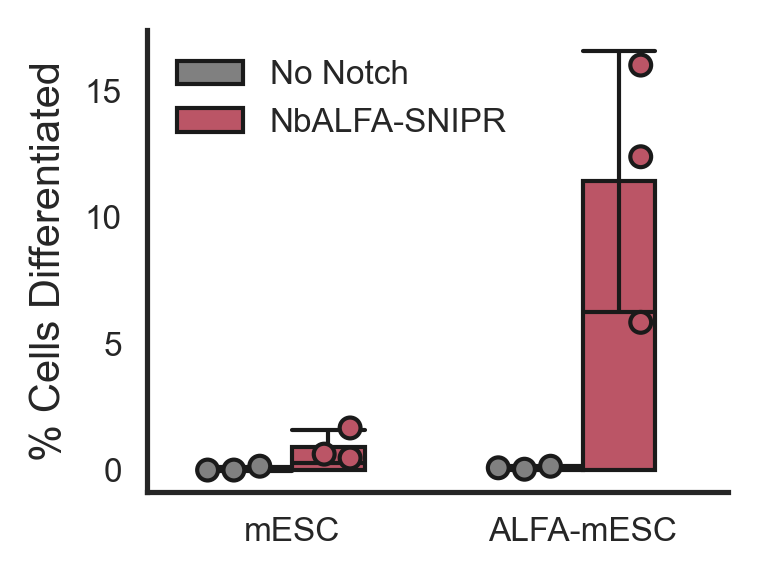

In [11]:
notches = ['No Notch','NbALFA-SNIPR']
with sns.color_palette(['gray', '#bb5566']):
    fig, ax = plt.subplots(1,1,figsize=(2.5,2), dpi=300)
    g = sns.swarmplot(data=df_summary[df_summary['Ratio']=="1:1"], x='Sender', y='logAPC-A', hue='Receiver',
                  order=['mESC','ALFA-mESC'],
                  hue_order=notches, 
                  edgecolor='k', linewidth=1, dodge=True, legend=False)
    sns.barplot(data=df_summary[df_summary['Ratio']=="1:1"], x='Sender', y='logAPC-A', hue='Receiver',
                  order=['mESC','ALFA-mESC'],
                  hue_order=notches, 
            dodge=True, edgecolor='k', capsize=0.5, width=0.5, saturation=1,
                estimator='mean', errorbar='sd',
            err_kws={'linewidth': 1, 'color':'k'})
    #g.legend().remove()
    plt.legend(frameon=False)
    g.set_ylabel('% Cells Differentiated')
    g.set_xlabel('')
    #plt.xticks(rotation=0, ha='right')
    sns.despine()
    plt.savefig(outputdir+'synnotch_dif.pdf', bbox_inches='tight')

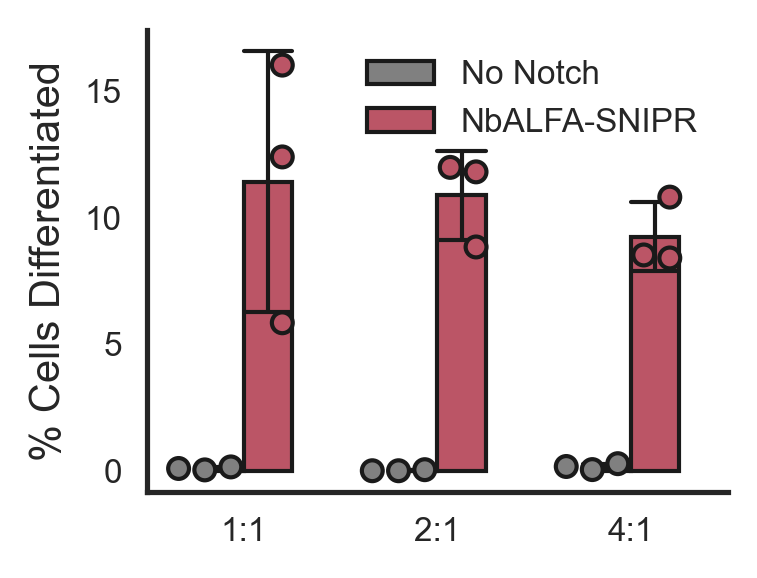

In [12]:
notches = ['No Notch','NbALFA-SNIPR']
with sns.color_palette(['gray', '#bb5566']):
    fig, ax = plt.subplots(1,1,figsize=(2.5,2), dpi=300)
    g = sns.swarmplot(data=df_summary[df_summary['Sender']=="ALFA-mESC"], x='Ratio', y='logAPC-A', hue='Receiver',
                  order=['1:1', '2:1', '4:1'],
                  hue_order=notches, 
                  edgecolor='k', linewidth=1, dodge=True, legend=False)
    sns.barplot(data=df_summary[df_summary['Sender']=="ALFA-mESC"], x='Ratio', y='logAPC-A', hue='Receiver',
                  order=['1:1', '2:1', '4:1'],
                  hue_order=notches, 
            dodge=True, edgecolor='k', capsize=0.5, width=0.5, saturation=1,
                estimator='mean', errorbar='sd',
            err_kws={'linewidth': 1, 'color':'k'})
    #g.legend().remove()
    plt.legend(frameon=False)
    g.set_ylabel('% Cells Differentiated')
    g.set_xlabel('')
    #plt.xticks(rotation=0, ha='right')
    sns.despine()
    plt.savefig(outputdir+'synnotch_dif_ratios.pdf', bbox_inches='tight')

In [13]:
notches = ['No Notch', 'NGN-SNIPR']
filters = ((df2['logDAPI-A'] > 3.5) &
           (df2.Receiver.isin(notches)))
df_summary = (df2[filters]
              .groupby(['Sender','Receiver','Ratio','Replicate'])['APC-A']
              .agg(np.mean)
              .reset_index())
df_summary = df_summary.replace('NGN-SNIPR','NbALFA-SNIPR')

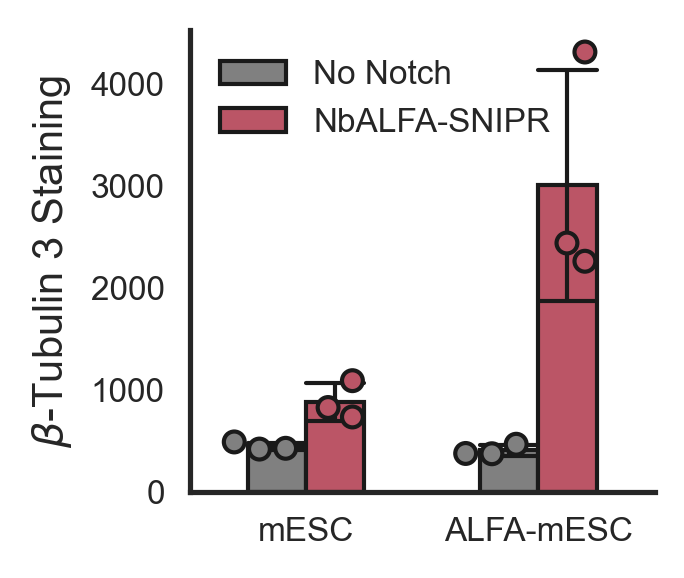

In [14]:
notches = ['No Notch','NbALFA-SNIPR']
with sns.color_palette(['gray', '#bb5566']):
    fig, ax = plt.subplots(1,1,figsize=(2,2), dpi=300)
    g = sns.swarmplot(data=df_summary[df_summary['Ratio']=="1:1"], x='Sender', y='APC-A', hue='Receiver',
                  order=['mESC','ALFA-mESC'],
                  hue_order=notches, 
                  edgecolor='k', linewidth=1, dodge=True, legend=False)
    sns.barplot(data=df_summary[df_summary['Ratio']=="1:1"], x='Sender', y='APC-A', hue='Receiver',
                  order=['mESC','ALFA-mESC'],
                  hue_order=notches, 
            dodge=True, edgecolor='k', capsize=0.5, width=0.5, saturation=1,
                estimator='mean', errorbar='sd',
            err_kws={'linewidth': 1, 'color':'k'})
    #g.legend().remove()
    plt.legend(frameon=False)
    g.set_ylabel(r'$\beta$-Tubulin 3 Staining')
    g.set_xlabel('')
    #plt.xticks(rotation=0, ha='right')
    sns.despine()
    plt.savefig(outputdir+'synnotch_staining.pdf', bbox_inches='tight')